In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 1. Augmentation을 적용한 데이터셋 만들기

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [4]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)

120


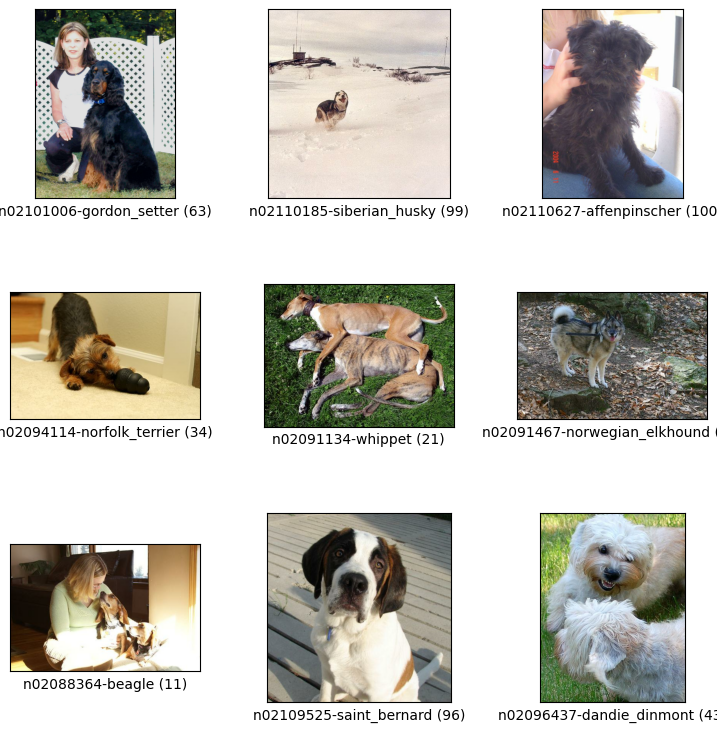

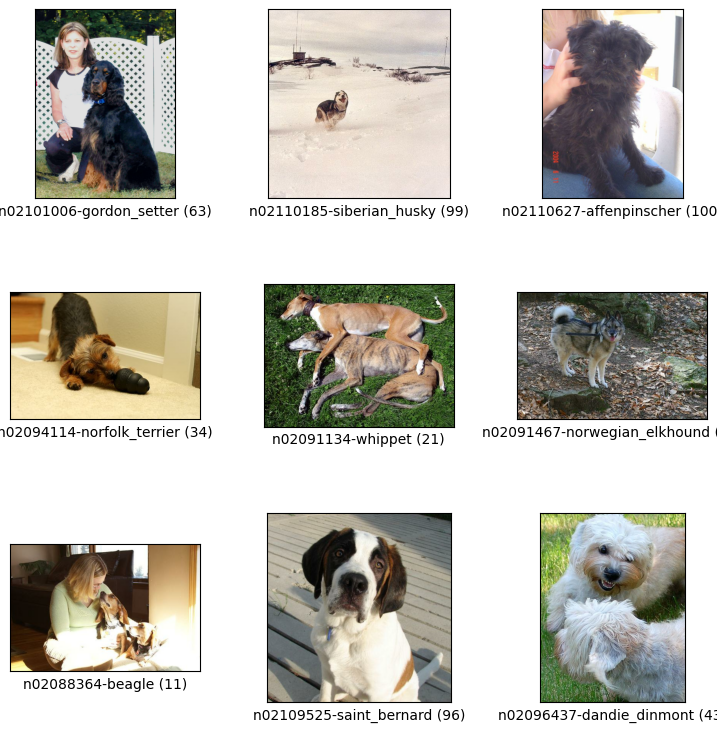

In [5]:
tfds.show_examples(ds_train, ds_info)

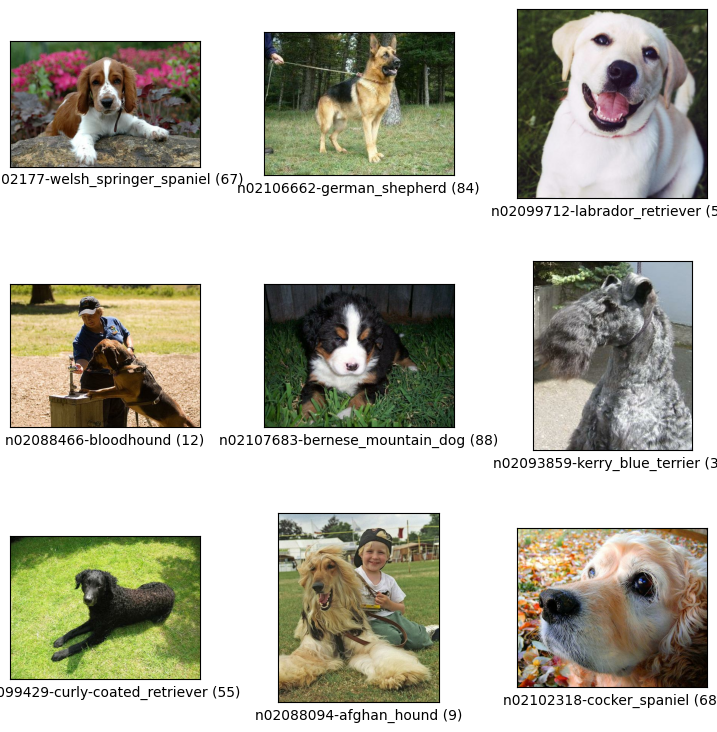

In [6]:
fig = tfds.show_examples(ds_test, ds_info)

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

## 1. Augmentation을 적용한 데이터셋 만들기

In [8]:
# augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [9]:
# one-hot encoding
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [10]:
# 데이터셋 가공
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# image_b는 사용하지 않더라도 두 이미지를 동시에 다룰 수 있도록 범용적인 함수
# cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

In [13]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

In [16]:
# 배치 단위의 mixup() 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [17]:
BATCH_SIZE = 16

ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

## 2. 모델 만들기

In [18]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):

    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [19]:
resnet50_no_aug = create_ResNet50()
resnet50_aug = create_ResNet50()
resnet50_aug_cutmix = create_ResNet50()
resnet50_aug_mixup = create_ResNet50()

## 3. 모델 훈련하기

In [20]:
def compile_fit(model,
                    ds_train,
                    ds_test,
                    ds_info,
                    batch_size=16,
                    epochs=15):

    model.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

In [21]:
history_resnet50_no_aug = compile_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    16,
    10
)

Epoch 1/10
750/750 [==============================] - 204s 238ms/step - loss: 2.2038 - accuracy: 0.4507 - val_loss: 3.6694 - val_accuracy: 0.1588
Epoch 2/10
750/750 [==============================] - 159s 212ms/step - loss: 0.6872 - accuracy: 0.8108 - val_loss: 1.1195 - val_accuracy: 0.6691
Epoch 3/10
750/750 [==============================] - 158s 210ms/step - loss: 0.2714 - accuracy: 0.9396 - val_loss: 0.9968 - val_accuracy: 0.7065
Epoch 4/10
750/750 [==============================] - 158s 211ms/step - loss: 0.0870 - accuracy: 0.9890 - val_loss: 0.9417 - val_accuracy: 0.7295
Epoch 5/10
750/750 [==============================] - 158s 211ms/step - loss: 0.0311 - accuracy: 0.9984 - val_loss: 0.9151 - val_accuracy: 0.7407
Epoch 6/10
750/750 [==============================] - 172s 229ms/step - loss: 0.0173 - accuracy: 0.9992 - val_loss: 0.9289 - val_accuracy: 0.7386
Epoch 7/10
750/750 [==============================] - 172s 229ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.9437 -

In [22]:
history_resnet50_aug = compile_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    16,
    10
)

Epoch 1/10
750/750 [==============================] - 178s 211ms/step - loss: 2.2746 - accuracy: 0.4272 - val_loss: 3.4137 - val_accuracy: 0.2021
Epoch 2/10
750/750 [==============================] - 157s 209ms/step - loss: 0.9441 - accuracy: 0.7346 - val_loss: 1.1698 - val_accuracy: 0.6609
Epoch 3/10
750/750 [==============================] - 157s 209ms/step - loss: 0.4931 - accuracy: 0.8649 - val_loss: 1.0132 - val_accuracy: 0.7031
Epoch 4/10
750/750 [==============================] - 157s 209ms/step - loss: 0.2568 - accuracy: 0.9398 - val_loss: 1.1318 - val_accuracy: 0.6811
Epoch 5/10
750/750 [==============================] - 171s 228ms/step - loss: 0.1768 - accuracy: 0.9617 - val_loss: 1.0097 - val_accuracy: 0.7127
Epoch 6/10
750/750 [==============================] - 157s 209ms/step - loss: 0.0850 - accuracy: 0.9869 - val_loss: 1.0215 - val_accuracy: 0.7179
Epoch 7/10
750/750 [==============================] - 171s 228ms/step - loss: 0.0485 - accuracy: 0.9947 - val_loss: 0.9785 -

In [23]:
history_resnet50_aug_cutmix = compile_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    16,
    10
)

Epoch 1/10
750/750 [==============================] - 195s 232ms/step - loss: 3.8005 - accuracy: 0.2148 - val_loss: 3.2552 - val_accuracy: 0.2203
Epoch 2/10
750/750 [==============================] - 159s 212ms/step - loss: 2.9287 - accuracy: 0.4371 - val_loss: 1.3340 - val_accuracy: 0.6286
Epoch 3/10
750/750 [==============================] - 173s 230ms/step - loss: 2.6256 - accuracy: 0.5288 - val_loss: 1.2775 - val_accuracy: 0.6497
Epoch 4/10
750/750 [==============================] - 159s 211ms/step - loss: 2.3989 - accuracy: 0.6078 - val_loss: 1.1896 - val_accuracy: 0.6630
Epoch 5/10
750/750 [==============================] - 158s 211ms/step - loss: 2.2751 - accuracy: 0.6483 - val_loss: 1.2768 - val_accuracy: 0.6554
Epoch 6/10
750/750 [==============================] - 158s 211ms/step - loss: 2.1763 - accuracy: 0.6796 - val_loss: 1.2493 - val_accuracy: 0.6726
Epoch 7/10
750/750 [==============================] - 158s 211ms/step - loss: 2.0813 - accuracy: 0.7159 - val_loss: 1.1293 -

In [24]:
history_resnet50_aug_mixup = compile_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    16,
    10
)

Epoch 1/10
750/750 [==============================] - 180s 213ms/step - loss: 3.7599 - accuracy: 0.2298 - val_loss: 3.8234 - val_accuracy: 0.1353
Epoch 2/10
750/750 [==============================] - 159s 212ms/step - loss: 2.8592 - accuracy: 0.4708 - val_loss: 1.4636 - val_accuracy: 0.5927
Epoch 3/10
750/750 [==============================] - 173s 231ms/step - loss: 2.6194 - accuracy: 0.5708 - val_loss: 1.4478 - val_accuracy: 0.5982
Epoch 4/10
750/750 [==============================] - 159s 212ms/step - loss: 2.4126 - accuracy: 0.6452 - val_loss: 1.2258 - val_accuracy: 0.6573
Epoch 5/10
750/750 [==============================] - 172s 230ms/step - loss: 2.2613 - accuracy: 0.7017 - val_loss: 1.2237 - val_accuracy: 0.6635
Epoch 6/10
750/750 [==============================] - 159s 211ms/step - loss: 2.1626 - accuracy: 0.7393 - val_loss: 1.3371 - val_accuracy: 0.6374
Epoch 7/10
750/750 [==============================] - 173s 231ms/step - loss: 2.0862 - accuracy: 0.7665 - val_loss: 1.2531 -

## 4. 훈련 과정 시각화하기

<ipython-input-32-844b79f628d2>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)


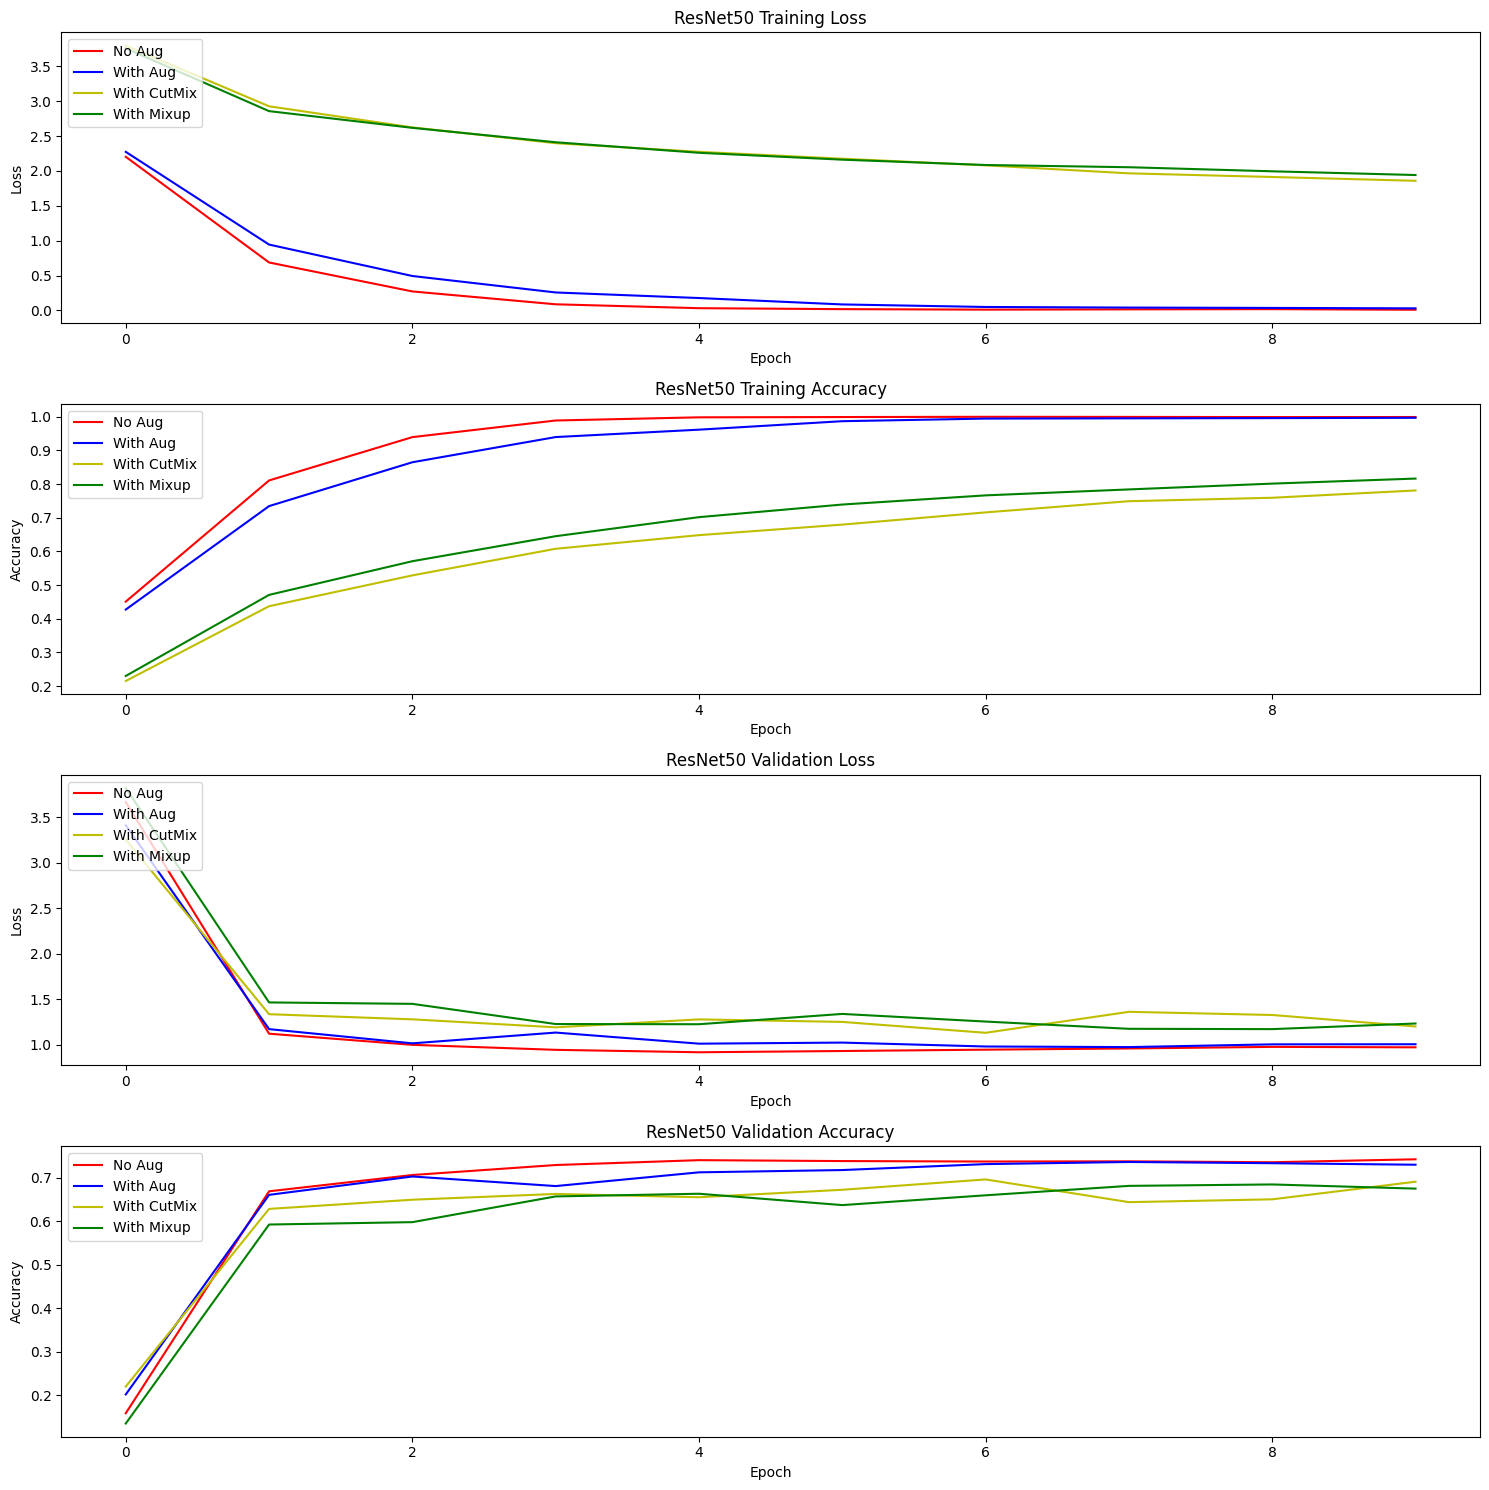

In [32]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.show()

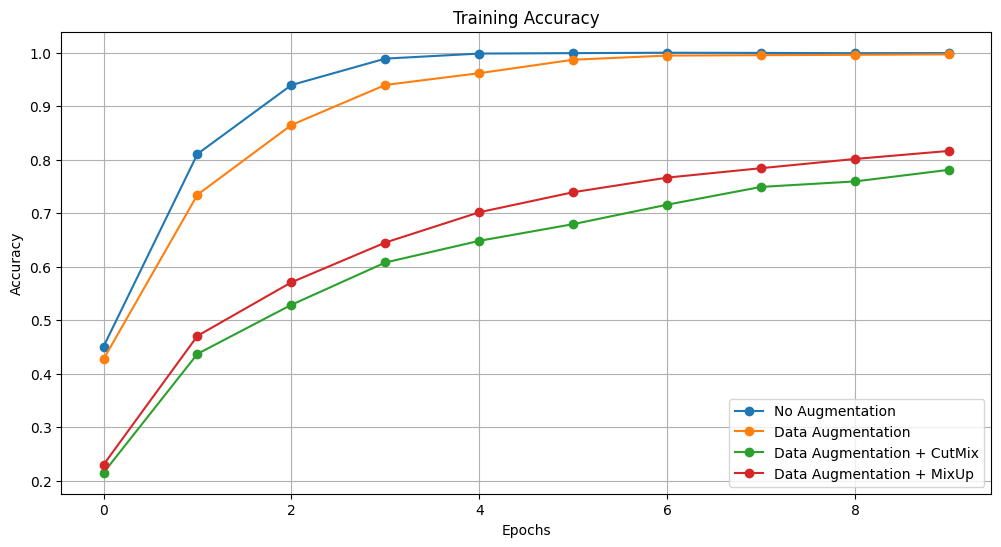

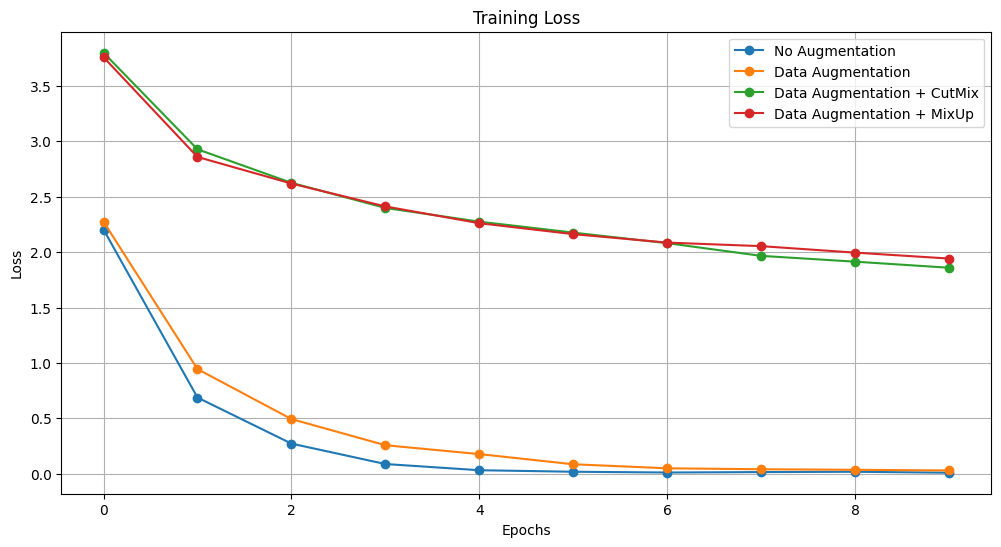

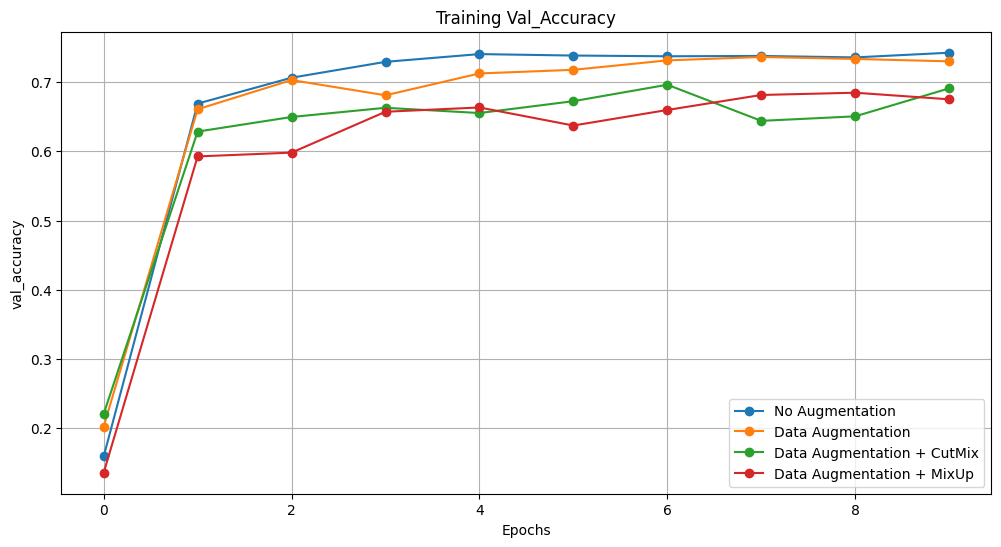

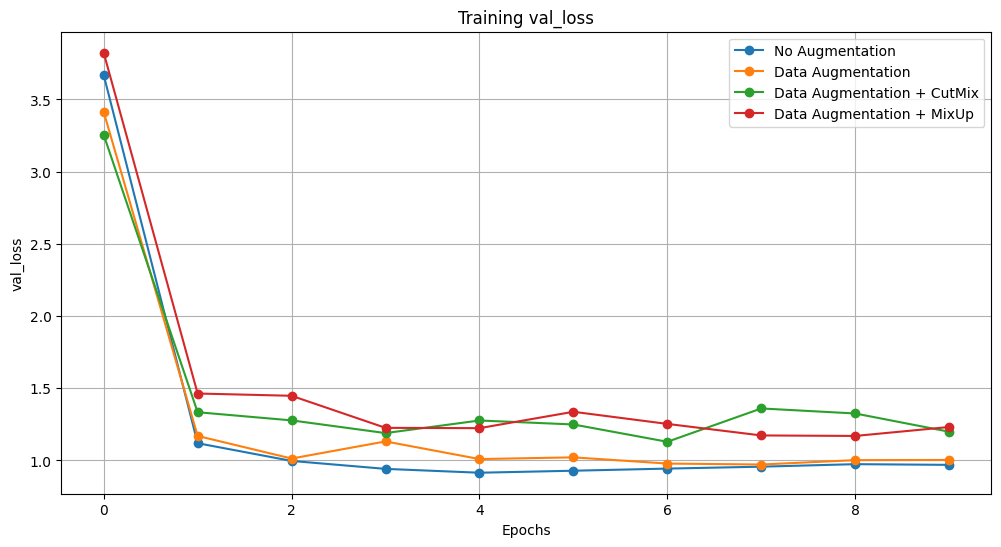

In [38]:
# 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(history_resnet50_no_aug.history['accuracy'], label='No Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug.history['accuracy'], label='Data Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], label='Data Augmentation + CutMix', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], label='Data Augmentation + MixUp', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.grid(True)
plt.show()

# 손실 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(history_resnet50_no_aug.history['loss'], label='No Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug.history['loss'], label='Data Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_cutmix.history['loss'], label='Data Augmentation + CutMix', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_mixup.history['loss'], label='Data Augmentation + MixUp', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 검증 데이터 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], label='No Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug.history['val_accuracy'], label='Data Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], label='Data Augmentation + CutMix', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], label='Data Augmentation + MixUp', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.legend()
plt.title('Training Val_Accuracy')
plt.grid(True)
plt.show()

# 검증 데이터 손실 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(history_resnet50_no_aug.history['val_loss'], label='No Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug.history['val_loss'], label='Data Augmentation', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], label='Data Augmentation + CutMix', linestyle='-', marker='o')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], label='Data Augmentation + MixUp', linestyle='-', marker='o')
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend()
plt.title('Training val_loss')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

In [42]:
import pandas as pd

# 데이터 프레임 생성
model_names = ['No Augmentation', 'Data Augmentation', 'Data Augmentation + CutMix', 'Data Augmentation + MixUp']
model_histories = [history_resnet50_no_aug, history_resnet50_aug, history_resnet50_aug_cutmix, history_resnet50_aug_mixup]

data = {
    'Model': model_names,
    'Average Loss': [sum(hist.history['loss']) / len(hist.history['loss']) for hist in model_histories],
    'Average Accuracy': [sum(hist.history['accuracy']) / len(hist.history['accuracy']) for hist in model_histories],
    'Average Validation Loss': [sum(hist.history['val_loss']) / len(hist.history['val_loss']) for hist in model_histories],
    'Average Validation Accuracy': [sum(hist.history['val_accuracy']) / len(hist.history['val_accuracy']) for hist in model_histories]
}

df = pd.DataFrame(data)

df

,Model,Average Loss,Average Accuracy,Average Validation Loss,Average Validation Accuracy
0,No Augmentation,0.334839,0.918600,1.241583,0.669718
1,Data Augmentation,0.438256,0.889825,1.271569,0.660972
2,Data Augmentation + CutMix,2.402603,0.612200,1.459615,0.617188
3,Data Augmentation + MixUp,2.415337,0.652608,1.534919,0.598577


## 회고

- augmentation을 적용하지 않은 데이터셋이 가장 좋은 성능을 보였다.
- 에폭을 1010번밖에 안돌려서 성능이 낮을 수도 있지만, cutmix와 mixup의 효과는 없었다.
= Data augmentation이 항상 좋은 결과는 가져오진 못한다.